In [1]:
import torch
import torch.nn as nn
import numpy as np

# Define the neural network model
class SolutionNN(nn.Module):
    def __init__(self):
        super(SolutionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 50),  # Input layer for (x, y)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)    # Output layer for u(x, y)
        )

    def forward(self, x):
        return self.network(x)

# Loss function
def monge_ampere_loss(model, points, f_value):
    # Ensure gradients are tracked
    points.requires_grad_(True)

    # Predicted solution
    u_pred = model(points)

    # Compute second derivatives (Hessian) w.r.t inputs
    grad_u = torch.autograd.grad(u_pred, points, torch.ones_like(u_pred), create_graph=True)[0]
    hessian_u = torch.zeros((points.shape[0], 2, 2))
    for i in range(2):
        grad_u_i = grad_u[:, i].unsqueeze(1)
        hessian_u[:, i, :] = torch.autograd.grad(grad_u_i, points, torch.ones_like(grad_u_i), create_graph=True)[0]

    # Determinant of the Hessian
    det_hessian = hessian_u[:, 0, 0] * hessian_u[:, 1, 1] - hessian_u[:, 0, 1] * hessian_u[:, 1, 0]

    # PDE loss: difference between det(Hessian) and source function
    pde_loss = torch.mean((det_hessian - f_value) ** 2)

    return pde_loss

# Example usage
model = SolutionNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate points (simplified for illustration; use a grid or random points within the unit disk)
points = torch.rand(100, 2) * 2 - 1  # Points in [-1, 1]x[-1, 1]
f_value = 1  # Assuming a constant source function

# Training loop (simplified)
for epoch in range(5000):
    optimizer.zero_grad()
    loss = monge_ampere_loss(model, points, f_value)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.0029183626174927
Epoch 100, Loss: 0.010329894721508026
Epoch 200, Loss: 0.002456734189763665
Epoch 300, Loss: 0.0010168554726988077
Epoch 400, Loss: 0.0007690218044444919
Epoch 500, Loss: 0.0005646869540214539
Epoch 600, Loss: 0.000322896201396361
Epoch 700, Loss: 0.00015236185572575778
Epoch 800, Loss: 0.00010973985627060756
Epoch 900, Loss: 9.371249325340614e-05
Epoch 1000, Loss: 8.209973748307675e-05
Epoch 1100, Loss: 7.259647099999711e-05
Epoch 1200, Loss: 6.449200736824423e-05
Epoch 1300, Loss: 5.740575579693541e-05
Epoch 1400, Loss: 5.111171049065888e-05
Epoch 1500, Loss: 4.5476681407308206e-05
Epoch 1600, Loss: 4.042457658215426e-05
Epoch 1700, Loss: 3.590461710700765e-05
Epoch 1800, Loss: 3.187144466210157e-05
Epoch 1900, Loss: 2.828351171046961e-05
Epoch 2000, Loss: 2.509835576347541e-05
Epoch 2100, Loss: 2.2281708879745565e-05
Epoch 2200, Loss: 1.9802020688075572e-05
Epoch 2300, Loss: 1.7629914509598166e-05
Epoch 2400, Loss: 1.5735135093564168e-05
Epoch 2500,

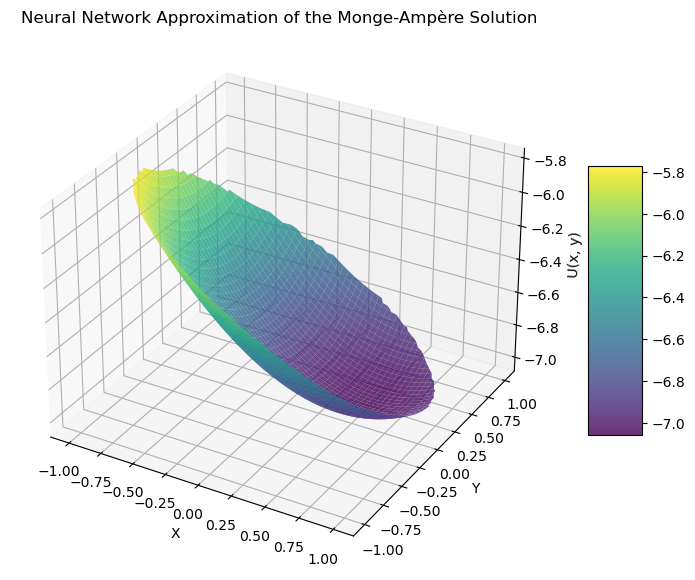

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# Generate a grid for visualization
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)

# Predict using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    Z_pred = model(xy).numpy().reshape(X.shape)

# Mask out points outside the unit disk for visualization purposes
mask = X**2 + Y**2 <= 1
Z_pred_masked = np.ma.masked_where(~mask, Z_pred)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_pred_masked, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_title('Neural Network Approximation of the Monge-Ampère Solution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U(x, y)')
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
